In [2]:
# CartPole-v1 using Q-learning

import gym
import cartpole
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Linear regression
from sklearn.linear_model import LinearRegression

from collections import deque

import random

from tensorflow import keras

from tqdm import tqdm

import multiprocessing

import time

sns.set_style("darkgrid")

In [5]:
class solver:
    def __init__(self, state_space, action_space, max_memory=5_000, epsilon_exploration = 1, exploration_decay = 0.9995,gamma = 0.95):
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon_exploration = epsilon_exploration
        self.exploration_decay = exploration_decay
        self.gamma = gamma
        #self.discount = discount

        #Define the memory
        self.memory = deque(maxlen = max_memory)

        #Define the model
        self.model_learn = self.get_model()
        self.model_predict = self.get_model()
        self.copy_model()

    def new_experience(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])

    def get_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(32, input_dim=self.state_space, activation='relu'))
        model.add(keras.layers.Dense(32, activation='relu')) #Hidden layer
        model.add(keras.layers.Dense(self.action_space, activation='linear')) #expected reward for each action
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.001, rho = 0.95, epsilon = 0.01), loss='mse')
        return model

    def copy_model(self):
        self.model_predict.set_weights(self.model_learn.get_weights())

    def act(self, state):
        #Explore
        if np.random.rand() <= self.epsilon_exploration:
            return np.random.randint(self.action_space) #Assuming start value is 0
        #Else exploit
        q_values = self.model_predict.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        #Get a batch of experiences
        batch_size = 20
        if len(self.memory) < batch_size:
            return
        else:
            batch = random.choices(self.memory, k=batch_size) #state, action, reward, next_state, done
            state, action, reward, next_state, done = map(np.array, zip(*batch))
                #Compute the target
                    #Applying the Bellman equation
            argmax = np.argmax(self.model_predict.predict(np.concatenate(next_state, axis=0), verbose=0), axis=1)
            target = reward + self.gamma * self.model_learn.predict(np.concatenate(next_state, axis=0), verbose=0)[np.arange(batch_size),argmax] * (1 - done)
            #Compute the target for the action
            target_f = self.model_learn.predict(np.concatenate(state), verbose=0)
            #update for each target on the action coordinate
            target_f[np.arange(len(action)), action] = target
            #Train the model
            state = np.concatenate(state)
            
            self.model_learn.fit(state, target_f, epochs=1, verbose=0, batch_size=1)

            self.epsilon_exploration *= self.exploration_decay
            self.epsilon_exploration = max(0.05, self.epsilon_exploration)
        
        #self.model.train_on_batch(state, target_f) #doesnt work the way I thought it would

In [6]:
#Training the model

nb_episodes = 200
state_dim = 4
action_dim = 2 # 2 actions : left, right

env_DQN = cartpole.CartPoleEnv(action_dim =action_dim)
agent = solver(state_dim, action_dim)
timesteps = 2
scores_DQN = list()
steps_history_DQN = list()
for episode in tqdm(range(nb_episodes)):
    state = env_DQN.reset()
    state = np.reshape(state, [1, state_dim])
    done = False
    score = 0
    steps  = 0
    while not done:
        steps += 1
        action = agent.act(state)
        next_state, reward, done, _ = env_DQN.step(action)
        next_state = np.reshape(next_state, [1, state_dim])
        if not done:
            reward = reward
        else:
            reward = -50
        agent.new_experience(state, action, reward, next_state, done)
        state = next_state
        score += reward
        agent.replay() #Learn from the experience
    if episode % timesteps == 0:
        agent.copy_model()
        scores_DQN.append(score)
        steps_history_DQN.append(steps)
        

#Save the model
agent.model_learn.save('model_DQN_double_more_epochs.h5')

  0%|          | 0/200 [00:00<?, ?it/s]2023-03-20 13:24:24.439708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-20 13:24:24.485929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-20 13:24:24.655598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 200/200 [37:20<00:00, 11.20s/it] 


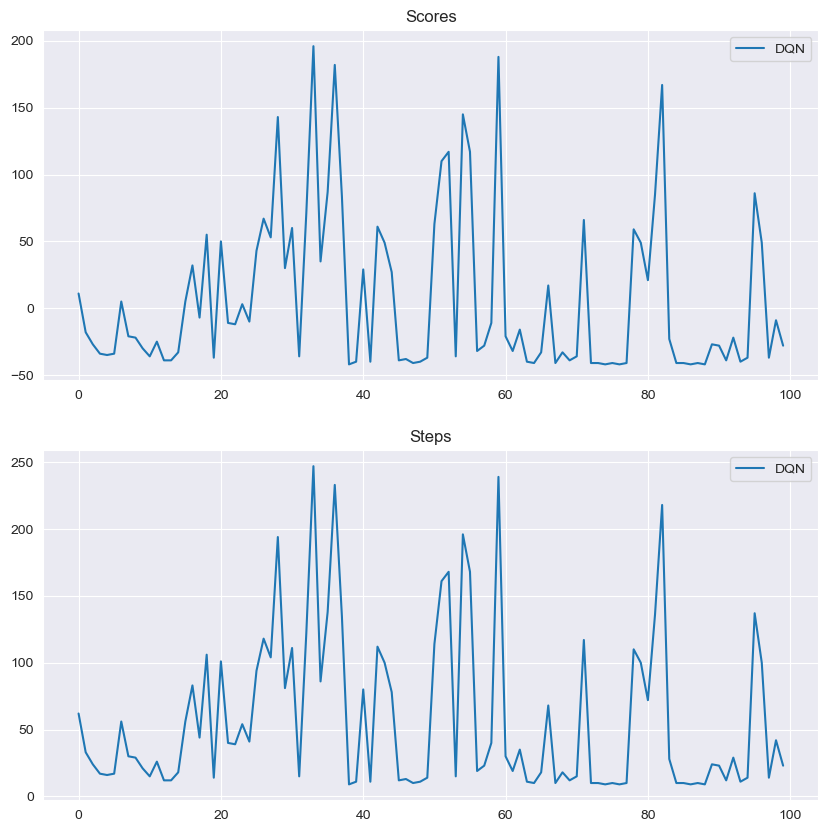

In [7]:


fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(scores_DQN, label='DQN')
axs[0].set_title('Scores')
axs[0].legend()
axs[1].plot(steps_history_DQN, label='DQN')
axs[1].set_title('Steps')
axs[1].legend()

plt.show()

## Failure, do not learn